# RVE Test 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import compmod2 as cp2
import argiope as ag
import pandas as pd
import numpy as np
from string import Template
import inspect, os, local_settings, scipy
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d as mpl3d
import matplotlib.colors as colors
import matplotlib as mpl
%matplotlib nbagg

In [3]:
# USEFUL FUNCTIONS
def create_dir(path):
    try:
        os.mkdir(path)
    except:
        pass
# SETTINGS
workdir   = "_workdir/"
outputdir = "outputs/"
label   = "RVE"
create_dir(workdir)
create_dir(workdir + outputdir)

## Model settings

In [4]:
%%time
nelt
shape = np.array([15, 15, 15])
Ne = shape.prod()

def element_map(mesh):
    mesh.elements.loc[:, ("type", "solver", "") ] = "C3D8R"
    return mesh
    
    
def material_map(mesh):
    mesh.elements.materials = ["mat{0}".format(i) for i in mesh.elements.index]
    return mesh

dist = cp2.distributions.Weibull(k = 1., l = 1.e-2)
xt, x = dist.discretize(Ne, xmax = 1.)
np.random.shuffle(x)
E = 210.e3
nu = .3
materials = [ag.materials.ElasticPerfectlyPlastic(
                                 label = "mat{0}".format(i+1), 
                                 young_modulus = E, 
                                 poisson_ratio = nu, 
                                 yield_stress = x[i] * E) 
                                 for i in range(Ne)]

steps = [cp2.models.RVEStep(name = "loading1", 
                            cx = ("disp", .1),
                            field_output_frequency = 100),
         cp2.models.RVEStep(name = "unloading1", 
                            cx = ("force", 0.),
                            field_output_frequency = 100),
         cp2.models.RVEStep(name = "loading2", 
                            cx = ("disp", .1),
                            field_output_frequency = 100),]

sample = cp2.models.RVESample(shape = shape,
                              element_map = element_map,
                              material_map = material_map)
model = cp2.models.RVETest(label = label,
                           parts = {"sample":sample},
                           steps = steps,
                           materials = materials,
                           solver = "abaqus", 
                           solver_path = local_settings.ABAQUS_PATH,
                           workdir = workdir,
                           verbose = True)

Wall time: 539 ms


## Solving

In [5]:
if True:
    model.write_input()
    model.run_simulation()
    model.postproc()
    model.save(workdir + label + ".pckl")

#### RUNNING "RVE" USING SOLVER "ABAQUS"
     Analysis initiated from SIMULIA established products
     Abaqus JOB RVE
     Abaqus 3DEXPERIENCE R2018x
     Abaqus License Manager checked out the following licenses:
     Abaqus/Standard checked out 5 tokens from Flexnet server flex2-symme.univ-savoie.fr.
     <80 out of 90 licenses remain available>.
     Begin Analysis Input File Processor
     5/22/2019 9:57:51 AM
     Run pre.exe
     5/22/2019 9:58:01 AM
     End Analysis Input File Processor
     Begin Abaqus/Standard Analysis
     5/22/2019 9:58:01 AM
     Run standard.exe
     5/22/2019 10:04:47 AM
     End Abaqus/Standard Analysis
     Begin Convert MFS to SFS
     5/22/2019 10:04:48 AM
     Run SMASimUtility.exe
     5/22/2019 10:04:48 AM
     End Convert MFS to SFS
     Abaqus JOB RVE COMPLETED
  => RAN RVE: DURATION = 423.66s
#### POST-PROCESSING "RVE" USING POST-PROCESSOR "ABAQUS"
     Abaqus License Manager checked out the following license(s):
     "cae" release 6.18 from 

## Post-Processing 

In [6]:
model = ag.utils.load(workdir + label + ".pckl")
data = model.data["history"]
data.head()

areas                     dimensions                          disp  \
             A1        A2        A3         L1        L2        L3        U1   
frame                                                                          
0      0.999995  0.999995  0.999995   1.000000  1.000000  1.000000  0.000000   
1      0.999873  1.000199  1.000199   1.000250  0.999924  0.999924  0.000250   
2      0.999694  1.000347  1.000347   1.000500  0.999847  0.999847  0.000500   
3      0.999468  1.000615  1.000615   1.000875  0.999727  0.999727  0.000875   
4      0.999084  1.000978  1.000979   1.001438  0.999542  0.999541  0.001437   

                           energies    ...      strains                      \
             U2        U3        We    ...          E22       E33      LE11   
frame                                  ...                                    
0      0.000000  0.000000  0.000000    ...     0.000000  0.000000  0.000000   
1     -0.000076 -0.000076  0.006411    ...    -0.000076 -0.000076  0.000250   
2     -0.000153 -0.000153  0.025041    ...    -0.000153 -0.000153  0.000500   
3     -0.000273 -0.000273  0.073971    ...    -0.000273 -0.000273  0.000875   
4     -0.000458 -0.000459  0.189020    ...    -0.000458 -0.000459  0.001436   

                               stress                time    volume  
           LE22      LE33         S11  S22  S33         t         V  
frame                                                                
0      0.000000  0.000000    0.000000  0.0  0.0  0.000000  0.999995  
1     -0.000076 -0.000076   51.599712  0.0  0.0  0.002500  1.000123  
2     -0.000153 -0.000153  101.409298  0.0  0.0  0.005000  1.000194  
3     -0.000273 -0.000273  172.829645  0.0  0.0  0.008750  1.000342  
4     -0.000458 -0.000459  272.860785  0.0  0.0  0.014375  1.000520  

[5 rows x 33 columns]

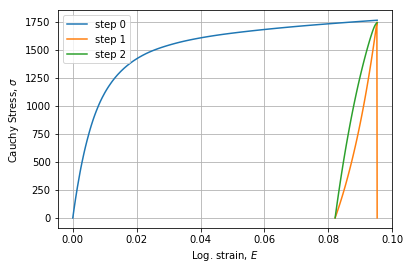

In [7]:
plt.figure()
for i in data.step.s.unique():
    step = data[data.step.s == i]
    plt.plot(step.strains.LE11, step.stress.S11, label = "step {0}".format(i))
plt.xlabel("Log. strain, $E$")
plt.ylabel("Cauchy Stress, $\sigma$")
plt.grid()
plt.legend(loc = "best")
plt.show()

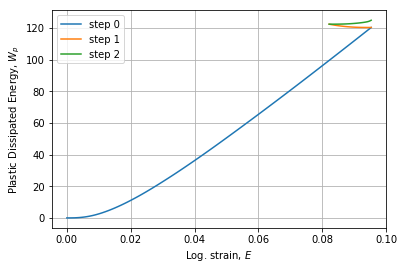

In [8]:
plt.figure()
for i in data.step.s.unique():
    step = data[data.step.s == i]
    plt.plot(step.strains.LE11, step.energies.Wp, label = "step {0}".format(i))
plt.xlabel("Log. strain, $E$")
plt.ylabel("Plastic Dissipated Energy, $W_p$")
plt.grid()
plt.legend(loc = "best")
plt.show()

## RVE plot

In [9]:
step_label = "loading1"
frame = -1
field_label = "LE"
component_label = "v11"

# FIELDS MANAGEMENT
fdata = model.parts["sample"].mesh.fields_metadata()
fields = model.parts["sample"].mesh.fields
F_id = fdata[(fdata.step_label == step_label) & (fdata.label == field_label)].sort_values("frame").index[frame]
F = fields[F_id].data[component_label]
fdata

,frame,frame_value,label,part,position,step_label,step_num
0,0,0,EE,ISAMPLE,element,loading1,0
1,0,0,LE,ISAMPLE,element,loading1,0
2,0,0,PE,ISAMPLE,element,loading1,0
3,0,0,S,ISAMPLE,element,loading1,0
4,0,0,U,ISAMPLE,node,loading1,0
5,1,0.831777,EE,ISAMPLE,element,loading1,0
6,1,0.831777,LE,ISAMPLE,element,loading1,0
7,1,0.831777,PE,ISAMPLE,element,loading1,0
8,1,0.831777,S,ISAMPLE,element,loading1,0
9,1,0.831777,U,ISAMPLE,node,loading1,0


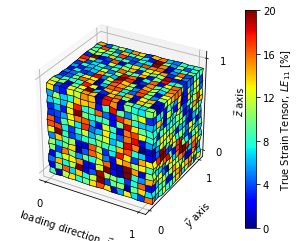

In [10]:
# PATCHES
vertices, emap = model.get_Poly3DCollection(deformed = True, 
                                            step_label = step_label, 
                                            frame = frame, 
                                            displacement_factor = 1.)
        
collection = mpl3d.art3d.Poly3DCollection(vertices)
collection.set_array(F.loc[emap] * 100)
collection.set_linewidth(.5)
collection.set_edgecolor("black")
collection.set_cmap(mpl.cm.jet)
collection.set_clim(0., 20.)

# FIGURE
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1, projection='3d', aspect = "equal")
ax1.add_collection3d(collection)
#ax1.axis("off")
ax1.set_xlabel(r'loading direction, $\vec x$ axis')
ax1.set_ylabel(r'$\vec y$ axis')
ax1.set_zlabel(r'$\vec z$ axis')
offset = .05
ax1.set_xlim3d(-offset, 1. + offset)
ax1.set_ylim3d(-offset, 1. + offset)
ax1.set_zlim3d(-offset, 1. + offset)
ax1.set_xticks([0, 1])
ax1.set_yticks([0, 1])
ax1.set_zticks([0, 1])
cbar = plt.colorbar(collection)
cbar.set_label(r"True Strain Tensor, $LE_{11}$ [$\%$]")
cbar.set_ticks(np.linspace(0., 20, 6))
plt.savefig("model.pdf")
plt.show()

## Periodic BC checking

In [11]:
U_id = fdata[(fdata.step_label == step_label) & (fdata.label == "U")].sort_values("frame").index[frame]
U = fields[U_id].data
nodes = model.parts["sample"].mesh.nodes

def check_direction(direction = "x"):
    """
    Calculates the difference of the displacements on 2 opposite faces that are normal to a given direction.
    """
    F0 = nodes[(nodes.sets.control == False) & (nodes.coords[direction] == 0.)].coords.sort_values(["x", "y", "z"])
    F1 = nodes[(nodes.sets.control == False) & (nodes.coords[direction] == 1.)].coords.sort_values(["x", "y", "z"])
    U0 = U.loc[F0.index].reset_index()
    U1 = U.loc[F1.index].reset_index()
    return U1 - U0

check_direction("x").describe()


,node,v1,v2,v3
count,256.0,2.560000e+02,256.0,256.0
mean,15.0,1.000000e-01,0.0,0.0
std,0.0,2.076048e-09,0.0,0.0
min,15.0,1.000000e-01,0.0,0.0
25%,15.0,1.000000e-01,0.0,0.0
50%,15.0,1.000000e-01,0.0,0.0
75%,15.0,1.000000e-01,0.0,0.0
max,15.0,1.000000e-01,0.0,0.0


In [12]:
check_direction("y").describe()

,node,v1,v2,v3
count,256.0,256.0,2.560000e+02,256.0
mean,240.0,0.0,-4.504636e-02,0.0
std,0.0,0.0,1.082354e-09,0.0
min,240.0,0.0,-4.504637e-02,0.0
25%,240.0,0.0,-4.504637e-02,0.0
50%,240.0,0.0,-4.504636e-02,0.0
75%,240.0,0.0,-4.504636e-02,0.0
max,240.0,0.0,-4.504636e-02,0.0


In [13]:
check_direction("z").describe()

,node,v1,v2,v3
count,256.0,256.0,256.0,2.560000e+02
mean,3840.0,0.0,0.0,-4.489214e-02
std,0.0,0.0,0.0,1.041044e-09
min,3840.0,0.0,0.0,-4.489214e-02
25%,3840.0,0.0,0.0,-4.489214e-02
50%,3840.0,0.0,0.0,-4.489214e-02
75%,3840.0,0.0,0.0,-4.489214e-02
max,3840.0,0.0,0.0,-4.489214e-02


The boundary conditions are perfectly matched. 